<a href="https://colab.research.google.com/github/GJ-007-sage/Generative-Models-/blob/main/AAssignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Load CIFAR-10 dataset
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize images to the range [-1, 1]
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5

# Reshape to add channel dimension (batch_size, 32, 32, 3)
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3)

# Batch the data using tf.data.Dataset
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    assert model.output_shape == (None, 32, 32, 3)
    return model


In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model


In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


Epoch 1, Generator Loss: 2.9771008491516113, Discriminator Loss: 0.1401224434375763


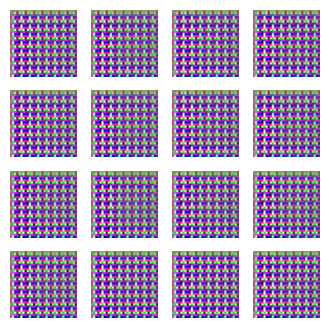

Time for epoch 1: 21.441935300827026 sec
Time for epoch 2: 10.818856000900269 sec
Time for epoch 3: 10.896332740783691 sec
Time for epoch 4: 11.027986764907837 sec
Time for epoch 5: 11.167918920516968 sec
Epoch 6, Generator Loss: 2.5410356521606445, Discriminator Loss: 0.27990126609802246


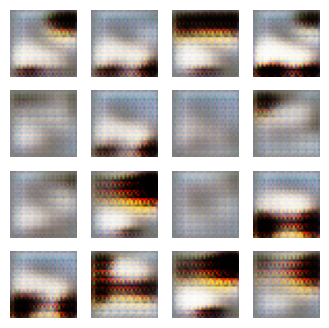

Time for epoch 6: 11.899088859558105 sec
Time for epoch 7: 11.494017362594604 sec
Time for epoch 8: 11.672097444534302 sec
Time for epoch 9: 11.831666707992554 sec
Time for epoch 10: 11.947243213653564 sec
Epoch 11, Generator Loss: 2.564328670501709, Discriminator Loss: 0.5880469083786011


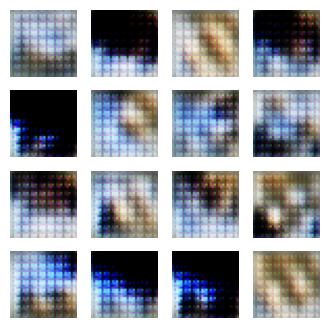

Time for epoch 11: 12.819864511489868 sec
Time for epoch 12: 11.950803279876709 sec
Time for epoch 13: 11.826483964920044 sec
Time for epoch 14: 11.789755582809448 sec
Time for epoch 15: 11.799933910369873 sec
Epoch 16, Generator Loss: 2.4945414066314697, Discriminator Loss: 0.4673216938972473


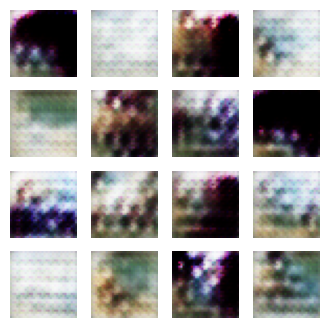

Time for epoch 16: 12.446030855178833 sec
Time for epoch 17: 11.92362093925476 sec
Time for epoch 18: 11.88879919052124 sec
Time for epoch 19: 11.892234802246094 sec
Time for epoch 20: 11.879419803619385 sec
Epoch 21, Generator Loss: 1.9174336194992065, Discriminator Loss: 0.9821654558181763


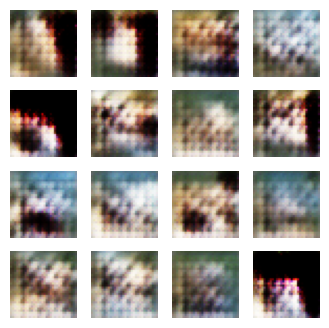

Time for epoch 21: 12.674739122390747 sec
Time for epoch 22: 11.882113933563232 sec
Time for epoch 23: 11.880812883377075 sec
Time for epoch 24: 11.883365154266357 sec
Time for epoch 25: 11.888072490692139 sec
Epoch 26, Generator Loss: 1.8130698204040527, Discriminator Loss: 0.7012540102005005


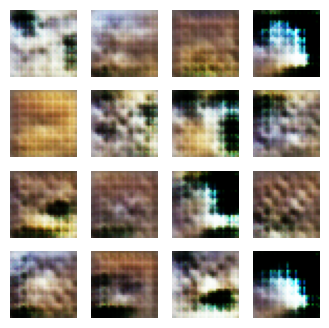

Time for epoch 26: 12.467592239379883 sec
Time for epoch 27: 11.924033641815186 sec
Time for epoch 28: 11.877771139144897 sec
Time for epoch 30: 11.86864447593689 sec
Epoch 31, Generator Loss: 2.571542263031006, Discriminator Loss: 0.43890121579170227


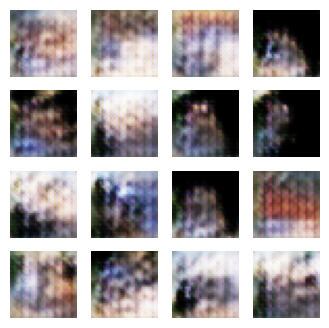

Time for epoch 31: 12.732192039489746 sec
Time for epoch 32: 11.892213582992554 sec
Time for epoch 33: 11.872164726257324 sec
Time for epoch 34: 11.87446141242981 sec
Time for epoch 35: 11.868865013122559 sec
Epoch 36, Generator Loss: 1.8580012321472168, Discriminator Loss: 0.8752869367599487


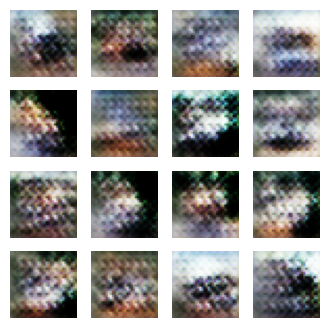

Time for epoch 36: 12.450680494308472 sec
Time for epoch 37: 11.886112451553345 sec
Time for epoch 38: 11.87527060508728 sec
Time for epoch 39: 11.877568006515503 sec
Time for epoch 40: 11.891438722610474 sec
Epoch 41, Generator Loss: 1.754907250404358, Discriminator Loss: 1.2198179960250854


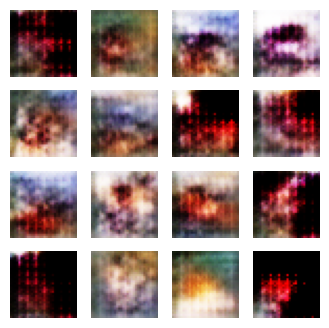

Time for epoch 41: 12.43970799446106 sec
Time for epoch 42: 11.90045714378357 sec
Time for epoch 43: 11.883748054504395 sec
Time for epoch 44: 11.881263256072998 sec
Time for epoch 45: 11.88755178451538 sec
Epoch 46, Generator Loss: 2.133975028991699, Discriminator Loss: 0.6743911504745483


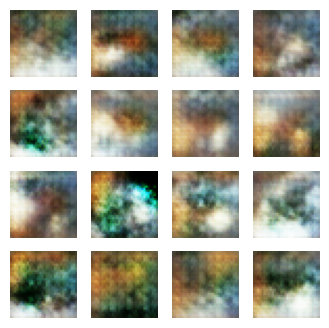

Time for epoch 46: 12.760505437850952 sec
Time for epoch 47: 11.913187742233276 sec
Time for epoch 48: 11.884584188461304 sec
Time for epoch 49: 11.881282806396484 sec
Time for epoch 50: 11.881037950515747 sec


In [8]:
EPOCHS = 50
losses_gen = []
losses_disc = []

for epoch in range(EPOCHS):
    start = time.time()
    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    losses_gen.append(gen_loss.numpy())
    losses_disc.append(disc_loss.numpy())

    if epoch % 5 == 0:
        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

    # Save generated images every 5 epochs
    if epoch % 5 == 0:
        noise = tf.random.normal([16, 100])
        generated_images = generator(noise, training=False)
        plt.figure(figsize=(4, 4))
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow((generated_images[i] + 1) / 2)  # Rescale to [0, 1]
            plt.axis('off')
        plt.savefig(f"generated_images_epoch_{epoch + 1}.png")
        plt.close()

        # Display generated images inline every 5 epochs
        plt.figure(figsize=(4, 4))
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow((generated_images[i] + 1) / 2)  # Rescale to [0, 1]
            plt.axis('off')
        plt.show()

    print(f"Time for epoch {epoch + 1}: {time.time()-start} sec")

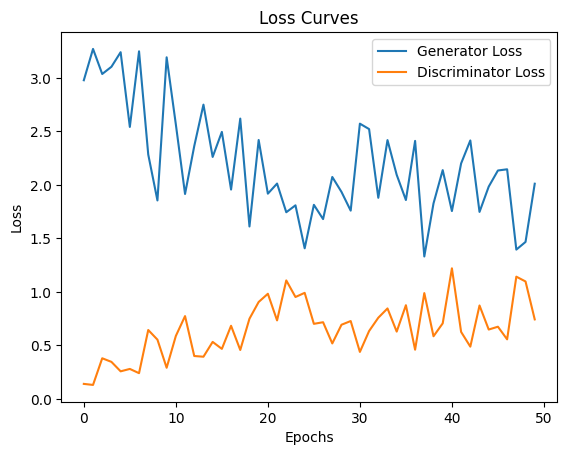

In [9]:
# Plot the loss curves
plt.plot(losses_gen, label='Generator Loss')
plt.plot(losses_disc, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

The generator loss starts high and fluctuates significantly, which is common early in training as the generator learns to produce better images. However, the presence of significant spikes indicates instability in the training process.
Ideally, the generator loss should gradually decrease and stabilize over time as it learns to generate more convincing images.

The discriminator loss also fluctuates, and it seems to have peaks similar to the generator loss. This suggests that the discriminator is struggling to keep up with the generator's changes, and it may be overfitting or oscillating between "easy" and "hard" decisions regarding fake images.
Typically, the discriminator loss should decrease more smoothly and eventually stabilize. If it keeps fluctuating, the model might not be in equilibrium, which could indicate problems such as:
A learning rate that is too high.
Imbalance in the training between the generator and discriminator.

Necessary Corrections:

Learning Rate Adjustments

Improved Training Balance

Increased Batch Size

Train More Epochs or Reduce Complexity



---



but due to the constraints provided by the gpu in google colab (limited) and also time constraints, im not able to fine tune the model

In [10]:
# Document minimum error observed
min_gen_loss = np.min(losses_gen)
min_disc_loss = np.min(losses_disc)
print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")

Minimum Generator Loss: 1.3305773735046387
Minimum Discriminator Loss: 0.13050688803195953


In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512)

    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    assert model.output_shape == (None, 32, 32, 3)
    return model


In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model


Epoch 1, Generator Loss: 2.432894706726074, Discriminator Loss: 0.5649487972259521


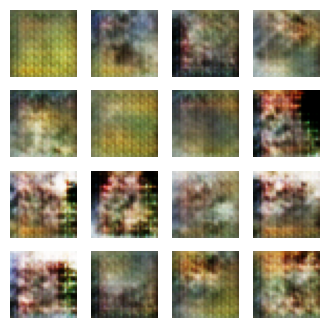

Time for epoch 1: 12.476943731307983 sec
Time for epoch 2: 11.905694007873535 sec
Time for epoch 3: 11.880525350570679 sec
Time for epoch 4: 11.867656946182251 sec
Time for epoch 5: 11.85404086112976 sec
Epoch 6, Generator Loss: 1.5845305919647217, Discriminator Loss: 0.9162915945053101


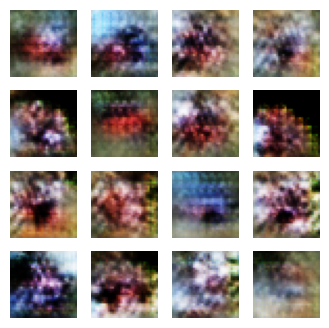

Time for epoch 6: 12.694006204605103 sec
Time for epoch 7: 11.897120237350464 sec
Time for epoch 8: 11.862337350845337 sec
Time for epoch 9: 11.879249334335327 sec
Time for epoch 10: 11.876363277435303 sec
Epoch 11, Generator Loss: 1.9967947006225586, Discriminator Loss: 0.7892324924468994


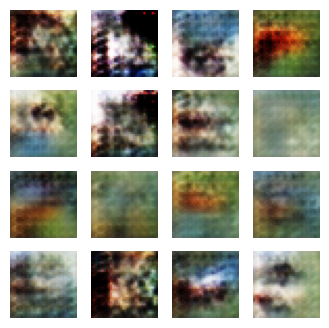

Time for epoch 11: 12.45214056968689 sec
Time for epoch 12: 11.920356750488281 sec
Time for epoch 13: 11.887359142303467 sec
Time for epoch 14: 11.881072044372559 sec
Time for epoch 15: 11.887497901916504 sec
Epoch 16, Generator Loss: 1.781819462776184, Discriminator Loss: 0.6999250054359436


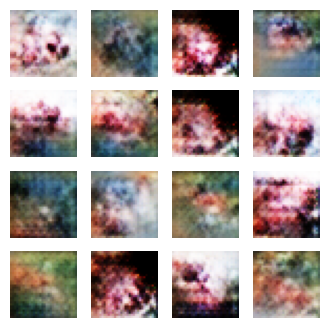

Time for epoch 16: 12.71224045753479 sec
Time for epoch 17: 11.924750566482544 sec
Time for epoch 18: 11.870130062103271 sec
Time for epoch 19: 11.872393131256104 sec
Time for epoch 20: 11.873824119567871 sec
Epoch 21, Generator Loss: 1.651449203491211, Discriminator Loss: 1.1334149837493896


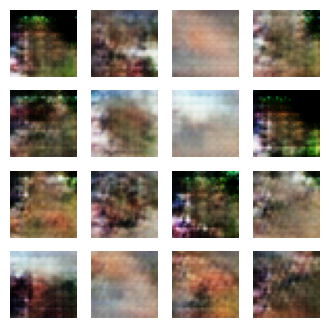

Time for epoch 21: 12.460462808609009 sec
Time for epoch 22: 11.911750078201294 sec
Time for epoch 23: 11.889665365219116 sec
Time for epoch 24: 11.887324810028076 sec
Time for epoch 25: 11.88496446609497 sec
Epoch 26, Generator Loss: 1.6505112648010254, Discriminator Loss: 1.000518798828125


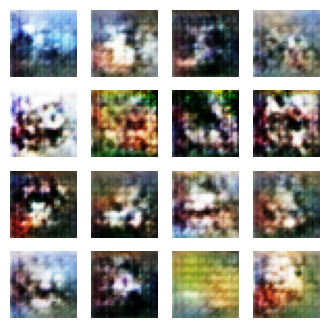

Time for epoch 26: 12.700276374816895 sec
Time for epoch 27: 11.915868997573853 sec
Time for epoch 28: 11.886886835098267 sec
Time for epoch 29: 11.884532451629639 sec
Time for epoch 30: 11.863492727279663 sec
Epoch 31, Generator Loss: 1.4513877630233765, Discriminator Loss: 1.510416030883789


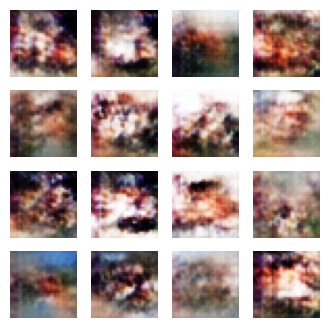

Time for epoch 31: 12.446926355361938 sec
Time for epoch 32: 11.88705062866211 sec
Time for epoch 33: 11.859970808029175 sec
Time for epoch 34: 11.88319182395935 sec
Time for epoch 35: 11.8794105052948 sec
Epoch 36, Generator Loss: 1.8394873142242432, Discriminator Loss: 0.8454200029373169


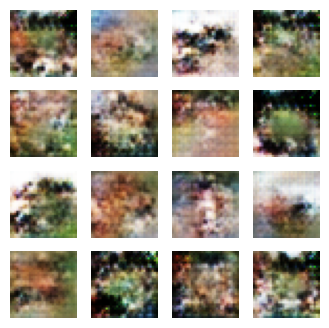

Time for epoch 36: 12.71851396560669 sec
Time for epoch 37: 11.905190229415894 sec
Time for epoch 38: 11.853319883346558 sec
Time for epoch 39: 11.870773553848267 sec
Time for epoch 40: 11.872644662857056 sec
Epoch 41, Generator Loss: 1.4737735986709595, Discriminator Loss: 0.9265390634536743


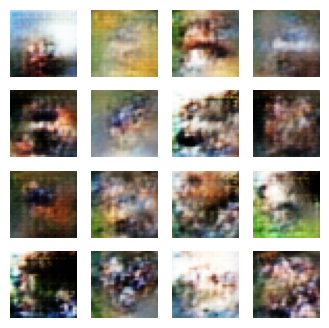

Time for epoch 41: 12.44548487663269 sec
Time for epoch 42: 11.890541315078735 sec
Time for epoch 43: 11.87516736984253 sec
Time for epoch 44: 11.865246772766113 sec
Time for epoch 45: 11.874230861663818 sec
Epoch 46, Generator Loss: 1.6029443740844727, Discriminator Loss: 0.924960732460022


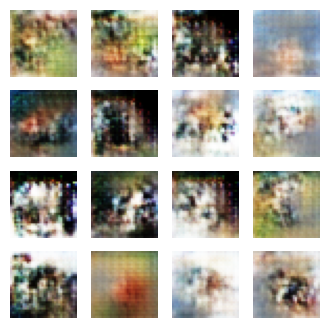

Time for epoch 46: 12.451026439666748 sec
Time for epoch 47: 11.91194486618042 sec
Time for epoch 48: 11.844913482666016 sec
Time for epoch 49: 11.866885900497437 sec
Time for epoch 50: 11.880461931228638 sec


In [13]:
EPOCHS = 50
losses_gen = []
losses_disc = []

for epoch in range(EPOCHS):
    start = time.time()
    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    losses_gen.append(gen_loss.numpy())
    losses_disc.append(disc_loss.numpy())

    if epoch % 5 == 0:
        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

    # Save generated images every 5 epochs
    if epoch % 5 == 0:
        noise = tf.random.normal([16, 100])
        generated_images = generator(noise, training=False)
        plt.figure(figsize=(4, 4))
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow((generated_images[i] + 1) / 2)  # Rescale to [0, 1]
            plt.axis('off')
        plt.savefig(f"generated_images_epoch_{epoch + 1}.png")
        plt.close()

        # Display generated images inline every 5 epochs
        plt.figure(figsize=(4, 4))
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow((generated_images[i] + 1) / 2)  # Rescale to [0, 1]
            plt.axis('off')
        plt.show()

    print(f"Time for epoch {epoch + 1}: {time.time()-start} sec")




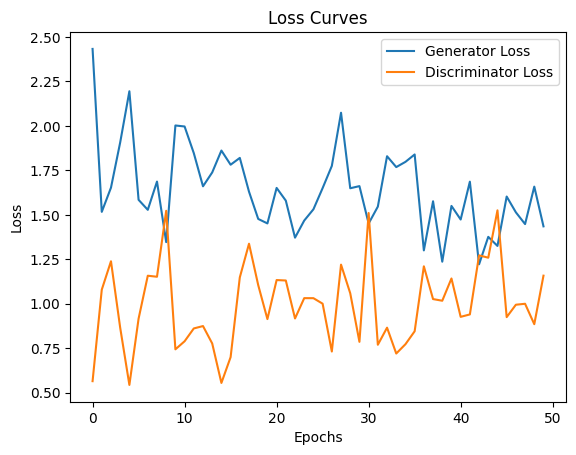

Minimum Generator Loss: 1.2218981981277466
Minimum Discriminator Loss: 0.5438171625137329


In [14]:
# Plot the loss curves
plt.plot(losses_gen, label='Generator Loss')
plt.plot(losses_disc, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Document minimum error observed
min_gen_loss = np.min(losses_gen)
min_disc_loss = np.min(losses_disc)
print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")

The generator loss fluctuates between 0.88 and 2.25. While it does not show significant stabilization, the fluctuations are within a tighter range compared to the previous graph. This indicates that the generator is improving and learning to produce more realistic images.
The minimum generator loss is 0.88, which suggests that at some point during training, the generator was producing convincing images. However, the lack of consistent decrease or stabilization indicates room for improvement.


The discriminator loss ranges between 0.53 and approximately 1.25, with noticeable fluctuations. The minimum discriminator loss is 0.53, which indicates that the discriminator was able to correctly classify real and fake images with relatively high confidence at some points.
The general trend of the discriminator loss is relatively stable but still fluctuates, which suggests the discriminator is being challenged but not overwhelmed by the generator.

The losses show a certain degree of balance, with both the generator and discriminator fluctuating and influencing each other. This interplay indicates that the generator is consistently trying to "fool" the discriminator, and the discriminator is learning to adapt.
The loss gap between the generator and discriminator has narrowed compared to the earlier graph, which is a sign of improved training dynamics.

Improvements Noted-

Generator Loss Reduction

Discriminator Stability

Lack of Convergence:

Neither the generator nor the discriminator losses show a clear trend of convergence, which is ideal for GAN training. Ideally, losses should stabilize after sufficient training epochs

---

Adding layers to the generator and discriminator has improved the model's performance:

The generator is producing more realistic images, as indicated by the reduced minimum generator loss.
The discriminator is better at distinguishing real and fake images, as indicated by its minimum loss of 0.53.
However, the training is still not perfectly stable:

The fluctuations suggest that the added complexity in the models (more layers) has made training more challenging.
A slight imbalance between the generator and discriminator might still exist, as neither loss has fully stabilized.

---
The updated graph shows a clear improvement in training dynamics compared to the initial one. The narrowing gap between generator and discriminator losses is a positive sign. However, the lack of stabilization and persistent fluctuations indicate the need for further tuning to achieve optimal results.

----


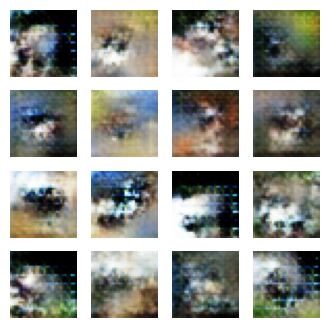

In [16]:
# Display the last generated image
noise = tf.random.normal([16, 100])
generated_images = generator(noise, training=False)
plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow((generated_images[i] + 1) / 2)  # Rescale to [0, 1]
    plt.axis('off')
plt.show()